In [1]:
import logging
from math import trunc
from operator import itemgetter
from pprint import pprint
import re
import boto3
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel
from gensim.models import TfidfModel
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.test.utils import datapath
import joblib
from nltk.corpus import stopwords
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
from rdflib import Namespace, XSD
from rdflib.namespace import SKOS
from scipy.stats import percentileofscore
from sklearn.feature_extraction.text import TfidfVectorizer
import sparql_util as su
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import spacy
from tqdm.auto import tqdm

###

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words = stopwords.words('english')

%pylab inline

/Users/tom.mctavish/Library/Caches/pypoetry/virtualenvs/match-2141-LieH_8B5-py3.9/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Populating the interactive namespace from numpy and matplotlib


/Users/tom.mctavish/Library/Caches/pypoetry/virtualenvs/match-2141-LieH_8B5-py3.9/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['trunc']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## S3 Config

In [2]:
bucket = 'dev-matchology-datascience'
fname = 'data/dice/research/LDA/'
prod_jobs = 'all_prod_jobs.json'
kgs = 'kg_jobs.csv'
model = '22_topics.model'
client = boto3.client('s3')

## All Dice.com jobs in production
Used Logstash to pull all job descriptions, skills, and titles from Dice.com. Later iterations will inlcude more historical data

In [3]:
client.download_file(bucket,fname+prod_jobs, prod_jobs)
df_prodjobs = pd.io.json.read_json('all_prod_jobs.json', lines=True)

In [4]:
assert len(df_prodjobs) == 77142

In [5]:
df_prodjobs.head()

,brandId,job_description,job_skills,enriched_epoch_datetime,job_title,id
0,dice,"Our client, a global network of professional f...","[Release, Management, PowerPoint, Excel, Adobe]",1.620001e+09,Release Management Coordinator,NaN
1,dice,Fully Remote Now offered for the following tim...,"[Computer, HTTP, Test, Development, Python, Ja...",1.620001e+09,Back End Software Engineer,NaN
2,dice,If you have a strong interest in joining a hig...,[Manager],1.620001e+09,Senior Product Manager,NaN
3,dice,DevOps Engineer - Must have active TS/SCI Thi...,"[Engineer, Systems, Python]",1.620002e+09,DevOps Engineer,NaN
4,dice,Senior DevOps Engineer - Fully Remote This Jo...,[Engineer],1.620001e+09,Senior Devops Engineer,NaN


### Normalize Job Titles to match up with Exact Terms in Knowledge Graph

At the time of this experiment, it wasn't fully clear if seniority was included in the knowledge graph. Also, I chose to make the assumption that there wouldn't be a significantly meaningful difference in the skills associated to a senior vs. junior role. For example, as a junior python developer, I will still have to have roughly all the same skills as a senior developer, with the difference in requisite years of experience.

In [6]:
seniority_patterns = [r'[sj]r._level_', r'^[seju]{2}nior[,_]*', r'[seju]{2}nior-?_', r',*_\(*[seju]{2}nior\)*_*', r'[seju]{2}nior\.',
                      r'senior[\/-]lead_', r'-[seju]{2}nior', r'[seju]{2}nior\/', r'[seju]{2}nior-level_', r'\/contract\/[seju]{2}nior',
                      r'\/[seju]{2}nior', r'[seju]{2}nior[-_]mid_', r'\/*[seju]{2}nior[-_]*level_?', r'\/*mid[-_]*level_?', r'mid[ -_to]{4}[seju]{2}nior[ -_]level[ -_]',
                      r'mid\/sr_level_', r'[-_]{,3}mid_level', r'[-_]{,3}mid', r'_level_\d+']
seniority_patterns = '|'.join(seniority_patterns)
df_prodjobs['match_column'] = df_prodjobs['job_title'].str.lower().str.replace(r'[ \(\)]|\\\/', '_', regex=True).str.replace(seniority_patterns, '', regex=True)

In [7]:
pd.DataFrame(df_prodjobs['job_title'].value_counts())

,job_title
Java Developer,582
Software Engineer,565
Business Analyst,492
Senior Software Engineer,482
Project Manager,481
...,...
Electrical Engineer (Onsite Job),1
Java Python Developer Remote Job.,1
Digital Marketing Compliance Associate,1
Tosca with Automation Tester,1


### show simple aggregation of job titles

In [8]:
df_top_jobs = pd.DataFrame(df_prodjobs['match_column'].value_counts())
df_top_jobs

,match_column
software_engineer,1096
java_developer,836
business_analyst,612
.net_developer,593
project_manager,589
...,...
associate_dca_engineer,1
technician_-_testing,1
motor_control_design_engineer,1
technical_services_operations_administrator,1


## Load all unique job titles from Neptune
Using our knowledge graph as the basis for normalizing job titles from Dice.com

***NOTE:***

must be connected to VPN in order to execute this query

In [9]:
SPARQL_ENDPOINT = "https://dev-taxonomy-neptune-cluster.cluster-cab44ucmi0fe.us-east-1.neptune.amazonaws.com:8182/sparql"
sparql = SPARQLWrapper(SPARQL_ENDPOINT)
DHI = Namespace("https://dhigroupinc.com/ns/core#")

### Optional Query to obtain all job titles

In [10]:
query = f"""
PREFIX skos: <{SKOS}>
PREFIX dhi: <{DHI}>

SELECT DISTINCT ?title
WHERE {{
    ?title a dhi:JobTitle .
    ?title skos:prefLabel ?prefLabel .
    filter langMatches(lang(?prefLabel), 'en-US')

}}
Group BY ?title

"""

sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
df_kg_jobs = su.sparql2df(results)

## Optional download from S3

In [11]:
client.download_file(bucket,fname+kgs, kgs)
df_kg_jobs = pd.read_csv('kg_jobs.csv')

In [12]:
df_kg_jobs

,title
0,https://dice.com/jobs/titles/Tax_Manager
1,https://dice.com/jobs/titles/Microsoft_Systems...
2,https://dice.com/jobs/titles/Data_Scientist
3,https://dice.com/jobs/titles/Database_Architect
4,https://dice.com/jobs/titles/Account_Executive
...,...
1604,https://dice.com/jobs/titles/Wire_Technician
1605,https://dice.com/jobs/titles/Performance_Test_...
1606,https://dice.com/jobs/titles/Appian_Developer
1607,https://dice.com/jobs/titles/AEM_Developer


#### Adjust RDF syntax to sync with dice.com titles

In [13]:
df_kg_jobs['matching_column'] = df_kg_jobs['title'].str.lower().str.replace(r'https://dice.com/jobs/titles/', '')

/var/folders/dq/jyh0mg4961zdw50nt390kp8spy7t02/T/ipykernel_10464/4163198688.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_kg_jobs['matching_column'] = df_kg_jobs['title'].str.lower().str.replace(r'https://dice.com/jobs/titles/', '')


### Top 20 most common jobs histogram

In [15]:
df_tj = df_top_jobs.iloc[:100].reset_index().rename(columns={'index': 'matching_column', 'match_column': 'count'})
df_tj

,matching_column,count
0,software_engineer,1096
1,java_developer,836
2,business_analyst,612
3,.net_developer,593
4,project_manager,589
...,...,...
95,mainframe_developer,48
96,cyber_security_analyst,48
97,controls_engineer,47
98,data_modeler,46


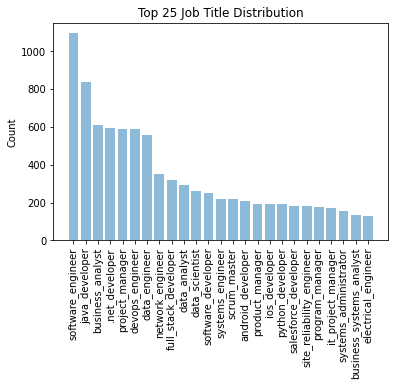

In [17]:
title = 'Top 25 Job Title Distribution'
plt.bar(df_tj['matching_column'].iloc[:25], df_tj['count'].iloc[:25], align='center', alpha=0.5)
plt.xticks(df_tj['matching_column'].iloc[:25], rotation=90)
plt.ylabel('Count')
plt.title(title)
plt.show()

## Build Training Data
Start by selecting jobs from Dice.com that match up to KG titles

In [18]:
cols = ['title', 'matching_column', 'count', 'job_description', 'job_skills', 'job_title']
df_lda_training = df_kg_jobs.merge(df_tj).merge(df_prodjobs, left_on='matching_column', right_on='match_column')[cols]
df_lda_training.head()

,title,matching_column,count,job_description,job_skills,job_title
0,https://dice.com/jobs/titles/Data_Scientist,data_scientist,263,Data Scientist – Ground-breaking Biopharma M...,"[python, r, RNAseq, Single-cell, T-cell]",Data Scientist
1,https://dice.com/jobs/titles/Data_Scientist,data_scientist,263,TOP Consulting is looking for a Data Scientist...,"[Advanced analytics, Data mining, Data science...",Data Scientist
2,https://dice.com/jobs/titles/Data_Scientist,data_scientist,263,US Tech Solutions is seeking a “Data Scientist...,"[Data analysis, Data QA, Data integration, Dat...",Data Scientist
3,https://dice.com/jobs/titles/Data_Scientist,data_scientist,263,"SaaS, AWS, Spark This Jobot Job is hosted by:...","[Security, Apache, Java, Python, SQL, API]",Senior Data Scientist
4,https://dice.com/jobs/titles/Data_Scientist,data_scientist,263,NLP / NLU Engineer Minimum 3 years of produ...,"[nlp, sql]",data scientist


## Text Processing
Define string patterns to adjust, stopwords to remove, and associated functions to apply said changes

In [19]:
regex_ref = {
    'punctuation': {
        'pattern': r'[•™\#\*\|\(\)"\?\@,:;“”·–_]+|\.(?!\w+)',
        'repl': r''
    },
    'slashes': {
        'pattern': r'/|-',
        'repl': r' '
    }, 
    'ampersand': {
        'pattern': r'&',
        'repl': r'and'
    }, 
    'info_tech': {
        'pattern': r' IT |i\.t\.|I\.T\.',
        'repl': r' information technology '
    }, 
    'period_typos': {
        'pattern': r'(?![a-z]+)\.(?=[A-z][a-z]+)',
        'repl': r' '
    },
    'camel_case': {
        'pattern': r'(?<=[a-z])([A-Z])(?! )',
        'repl': r' \1'
    },
    'unicode': {
        'pattern': r'\x01',
        'repl': r''
    },
    'urls': {
        'pattern': r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)|[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)',
        'repl': r''
    }
}

In [20]:
custom_stopwords = open('stopwords/lda_stopwords.txt', 'r').read()
custom_stopwords = custom_stopwords.split(',')

In [21]:
lemma_exceptions = {
    'datum': 'data',
    'aw': 'aws',
    'panda': 'pandas'
}

In [22]:
def IT_conversions(text, regex):
    info_tech = regex['info_tech']
    information_technology = re.sub(info_tech['pattern'], info_tech['repl'], text)
    return information_technology

In [23]:
def clean_urls(text, regex):
    urls = regex['urls']
    return re.sub(urls['pattern'], urls['repl'], text)

In [24]:
def remove_punctuation(text, regex):
    punc_regex = regex['punctuation']
    slashes = regex['slashes']
    ampersand = regex['ampersand']
    period_typos = regex['period_typos']
    unicode = regex['unicode']
    
    text = re.sub(punc_regex['pattern'], punc_regex['repl'], text)
    text = re.sub(slashes['pattern'], slashes['repl'], text)
    text = re.sub(ampersand['pattern'], ampersand['repl'], text)
    text = re.sub(period_typos['pattern'], period_typos['repl'], text)
    text = re.sub(unicode['pattern'], unicode['repl'], text)
    return text

In [25]:
def lowercase(text):
    return text.lower().split(' ')

In [26]:
def remove_stopwords(text, stopwords_file):
    return [w for w in text if w not in stopwords_file]

In [27]:
def camel_case(text, regex):
    return re.sub(regex['camel_case']['pattern'], regex['camel_case']['repl'], text)

In [28]:
def lemmatize(text, allowed_postags=['NOUN', 'PROPN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(' '.join(text))
    return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

In [29]:
def fix_lemmas(text, lemma, original):
    indices = [i for i, x in enumerate(text) if x == lemma]
    if len(indices) > 0:
        for i in indices:
            text[i] = original
    return text

In [30]:
def process_descriptions(text, regex, stopwords, lemma_exceptions):
    text = IT_conversions(text, regex)
    text = clean_urls(text, regex)
    text = remove_punctuation(text, regex)
    text = camel_case(text, regex)
    text = lowercase(text)
    text = lemmatize(text)
    text = remove_stopwords(text, stopwords)
    for lemma, original in lemma_exceptions.items():
        text = fix_lemmas(text, lemma, original)
    return text

#### Begin initial text processing job

In [32]:
tqdm.pandas()
df_lda_training['transformed_jds'] =df_lda_training.progress_apply(lambda x: process_descriptions(x['job_description'], 
                                                                                             regex_ref, 
                                                                                             custom_stopwords,
                                                                                             lemma_exceptions),
                                                              axis=1)

### N-grams
We take the inital cleaned tokens from the Job Descriptions and create bigrams and trigrams to ensure that longer key phrases are included as significant skills for model training

#### Create the bigram and trigram models
_Key Parameters_:
- __min_count__: minimum # of times an n-gram needs to occur in the corpus in order for it to be counted
- __threshold__: minimum score the n-gram needs to have in order to be counted. For more information on this class, see this [Gensim doc](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phrases), and for more information on the default scoring mechanism that is PMI-like ([Point-wise Mutual Information](https://en.wikipedia.org/wiki/Pointwise_mutual_information)), see [this paper](https://arxiv.org/abs/1310.4546)

In [33]:
bigram = Phrases(df_lda_training['transformed_jds'].values,
                 min_count=5, 
                 threshold=10, 
                 connector_words=ENGLISH_CONNECTOR_WORDS)

bigram_mod = Phraser(bigram)

trigram = Phrases(bigram[df_lda_training['transformed_jds'].values],
                         min_count=3, 
                         threshold=10, 
                         connector_words=ENGLISH_CONNECTOR_WORDS)

trigram_mod = Phraser(trigram)

In [34]:
def add_bigrams(bi_mod, documents):
    new_docs = []
    for idx in range(len(documents)):
        new_list = []
        for token in bi_mod[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                new_list.append(token)

        new_docs.append(new_list)
    return new_docs

In [35]:
def add_trigrams(tri_mod, bi_mod, documents, new_docs):
    for idx in range(len(documents)):
        new_list = []
        for token in tri_mod[bi_mod[documents[idx]]]:
            if '_' in token and token not in new_docs[idx]:
                # Token is a trigram, add to document.
                new_list.append(token)
        new_docs[idx] = new_docs[idx] + new_list
    return new_docs

### Combine n-grams
It's necessary to add the n-grams this way, otherwise the gensim Phraser model will clobber some lower-order ngrams in favor of higher-order ones. We want the complete picture to emcompass all combinations. For example, "data_scientist" is an obvious bigram of interest. However, we would not want to keep that at the expense of "data" and "scientist", as they can be useful unigrams on their own.

In [36]:
docs =df_lda_training['transformed_jds'].copy().values
bis = add_bigrams(bigram_mod, docs)
tris = add_trigrams(trigram_mod, bigram_mod, docs, bis)
for d in range(len(docs)):
    docs[d] = docs[d] + tris[d]

#### persist n-grams to dataframe

In [37]:
df_lda_training['n_grams'] = docs

### Incorporate Taxonomy artifacts and filter out skills
Using a massive file that combines all distinct skills and their higher level skills as defined in in [our taxonomy](https://confluence.dhigroupinc.com/display/MT/2021/01/29/Leveraging+the+Knowledge+Graph+for+Search), we are able to filter out anything that DHI doesn't officially recognize as a skill.

We perform this on the tokens that are augmented with n-grams so that we don't miss longer skills

In [38]:
dhi_skills = open('keepwords/dhi_skills_complete.txt', 'r').read()
dhi_skills = dhi_skills.replace(' ', '_').split('\n')

In [39]:
def skills_filter(text, keepwords, stopwords):
    keeps = [word for word in text if word in keepwords]
    filtered = [word for word in keeps if word not in stopwords]
    return filtered

In [41]:
df_lda_training['skills_only'] =df_lda_training.progress_apply(lambda x: skills_filter(x['n_grams'], dhi_skills, custom_stopwords), axis=1)

  0%|          | 0/10439 [00:00<?, ?it/s]

### Create the list of keepwords for our model to retain

In [42]:
dictionary_data = df_lda_training['skills_only'].explode()

### Create the model Corpus, Dictionary, & Bag of Words

In [46]:
data =df_lda_training['skills_only'].values
id2word = corpora.Dictionary(data)
id2word.filter_extremes(no_below=20, no_above=0.4, keep_tokens=dictionary_data.tolist())
corpus = [id2word.doc2bow(doc) for doc in data]
print(f'Number of unique tokens: {len(id2word)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 2797
Number of documents: 10439


### Optional Model instantiation and training (quick load below)
_Key Parameters_:
- __num_topics__: this is the _k_ value that can be optimized through maximizing coherence score, but it is ultimately based upon human intuition to interpret the topic results and see if there is a more appropriate number of topics to assign in the corpus
- __alpha__: a hyperparameter that can be tuned as a regularlizing mechanism. More tune-able in the single-core version of this Gensim model: LdaModel. Something to be revisited when scaling up the model

In [47]:
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=22, 
                         random_state=100,
                         eval_every=1,
                         chunksize=100,
                         passes=20,
                         alpha='symmetric',
                         per_word_topics=True)

#### Plot perplexity over model iterations
perplexity is a metric used for topic model utility. Further investigation is requiured, but essentially, the lower the perplexity, the better.


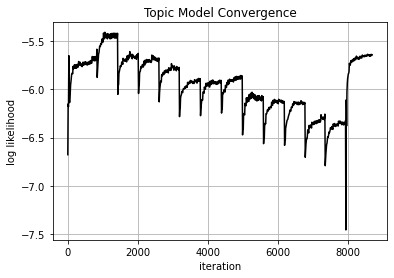

In [48]:
p = re.compile("(-*\\d+\\.\\d+) per-word .* (\\d+\\.\\d+) perplexity")
matches = [p.findall(l) for l in open('gensim.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter,liklihood,c="black")
plt.ylabel("log likelihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.savefig("convergence_likelihood.pdf")

#### model load & save helper functions

In [49]:
def save_model(model, path):
    temp_file = datapath(path)
    model.save(temp_file)

In [50]:
def load_model(path):
    return joblib.load(path)

In [52]:
# # save_model(lda_model, '22_topics.model')
lda_model = load_model(model)

### Generate word scores for tokens in cleaned Job Descriptions

In [53]:
def truncate(values):
    """
    provides a more contextually useful likelihood score than including all the significant digits that 
    come with standard floats
    """
    docs = {}
    for v in values:
        if v[1] > 1:
            res = v[1] - (trunc(v[1] - 0))
        else:
            res = v[1]
        docs[v[0]] = round(res, 7)
    return docs

In [54]:
def word_scores(docs, phi, dictionary):
    """
    Each collection of tokens will have a topic likelihood score, and then each token will have a likelihood score 
    associated to those said topics. The output scores are a result of multiplying the probability of the document's 
    topic with the word's probability of being in the prevailingly likely topic. For example:

    tokens = ['data', 'machine_learning', 'python', 'sql']
    document_probs = {'topic1': .75, 'topic2': .25}
    word_probs = {'data': {'topic1': .9, 'topic2': .1}, 
                  'machine_learning': {'topic1': .85, 'topic2': .15}, 
                  'python': {'topic1': .92, 'topic2': .08},
                  'sql': {'topic1': .55, 'topic2': .45}}

    result_scores = {'data': .9 * .75, 'machine_learning': .85 * .75, ...}
    """
    scores = {}
    for doc_topic, doc_topic_prob in docs.items():
        for word_id, word_topic_prob in phi.items():
            if doc_topic in word_topic_prob.keys():
                scores[dictionary[word_id]] = word_topic_prob[doc_topic] * doc_topic_prob
                
    return scores

In [55]:
def jd_word_scores(lda_model, dictionary, text, corpus):
    """
    takes a collection of tokens from a processed job description and returns a list of said tokens with 
    their respective word likelihood scores, scorted in descending order by score
    """
    bow = corpus[text.name]
    doc_topics, _, phi_values = lda_model.get_document_topics(bow, per_word_topics=True)
    docs = truncate(doc_topics)
    phi = {}
    
    for k, v in dict(phi_values).items():
        phi[k] = truncate(v)

    scores = word_scores(docs, phi, dictionary)

    return [sorted(doc_topics, key=lambda x: x[1], reverse=True), scores]

In [56]:
df_lda_training[['topics', 'word_scores']] =df_lda_training.progress_apply(lambda x: jd_word_scores(lda_model, id2word, x, corpus), 
                                                                      axis=1,
                                                                      result_type='expand')

  0%|          | 0/10439 [00:00<?, ?it/s]

### Compute average word likelihood scores by job title

In [57]:
def get_avg(word_scores):
    """
    Calculates the aggregate word likelihoods by job title. This helps normalize differences in word scores for varying 
    job descriptions with the same job titles. Also, it helps compensate for sub-optimal number of topics chosen at 
    model training time.
    """
    length = len(word_scores.values)
    agg_dict = {}
    
    for i in word_scores.values:
        for k, v in i.items():
            if k not in agg_dict.keys():
                agg_dict[k] = {'sum': v, 'count': 1}
            else:
                agg_dict[k] = {'sum': agg_dict[k]['sum'] + v, 'count': agg_dict[k]['count'] + 1}

    for v in agg_dict.values():
        v['avg'] = v['sum'] / length

    res_dict = {}

    for k, v in agg_dict.items():
        res_dict[k] = v['avg']

    scores = list(res_dict.values())
    for k, v in res_dict.items():
        res_dict[k] = {'avg_likelihood': v, 'percentile': percentileofscore(scores, v, kind='strict')}
    
    return res_dict

In [58]:
df_grouped = pd.DataFrame(df_lda_training.groupby('matching_column')['word_scores'].agg(lambda x: get_avg(x))).reset_index()
df_grouped.iloc[15:30]

,matching_column,word_scores
15,desktop_support,{'communication': {'avg_likelihood': 0.0194215...
16,desktop_support_technician,{'communication': {'avg_likelihood': 0.0330580...
17,developer,{'communication': {'avg_likelihood': 0.0146666...
18,devops_engineer,{'data': {'avg_likelihood': 0.0132890651292236...
19,electrical_engineer,{'communication': {'avg_likelihood': 0.0309259...
20,engineering_technician,{'system': {'avg_likelihood': 0.02423819375658...
21,enterprise_architect,{'most': {'avg_likelihood': 0.0132142145718847...
22,etl_developer,{'asap': {'avg_likelihood': 0.0178314510144685...
23,full_stack_developer,{'salary': {'avg_likelihood': 0.01487499712789...
24,full_stack_java_developer,{'management': {'avg_likelihood': 0.0310469203...


### Visualize initial results
We can plot the top scoring skills and their respective likelihoods for each job title in a basic ordered histogram

_Key Parameters:_

-__top_n:__ default is 25 but will control how many skills are plotted

To make a different sample selection, choose any of the valid job titles in "matching_column" in the grouped DF, and insert in place of "python_developer" in the cell that shows the first histogram below

In [59]:
def plot_skill_dist(example, top_n=25, show_plot=False):
    scores = example['word_scores'].values[0]
    new_scores = {}
    for k, v in scores.items():
        new_scores[k] = v['avg_likelihood']
    sort_scores = dict(sorted(new_scores.items(), key=itemgetter(1),reverse=True))
    if show_plot:
        fig, axs = plt.subplots(figsize = (20,10))
        t = example['matching_column'].values[0]
        title = f'Top {top_n} skills for {t}'
        skills = list(sort_scores.keys())[:top_n]
        likelihoods = list(sort_scores.values())[:top_n]
        plt.bar(skills, likelihoods, align='center', alpha=0.5)
        plt.xticks(skills, rotation=70)
        plt.ylabel('Likelihood')
        plt.title(title, size=20)
        plt.tick_params(labelsize=14)
        plt.show()
    return sort_scores

### Adjust for different titles by replacing "python_developer" with other titles that appear in the grouped table a couple of cells up

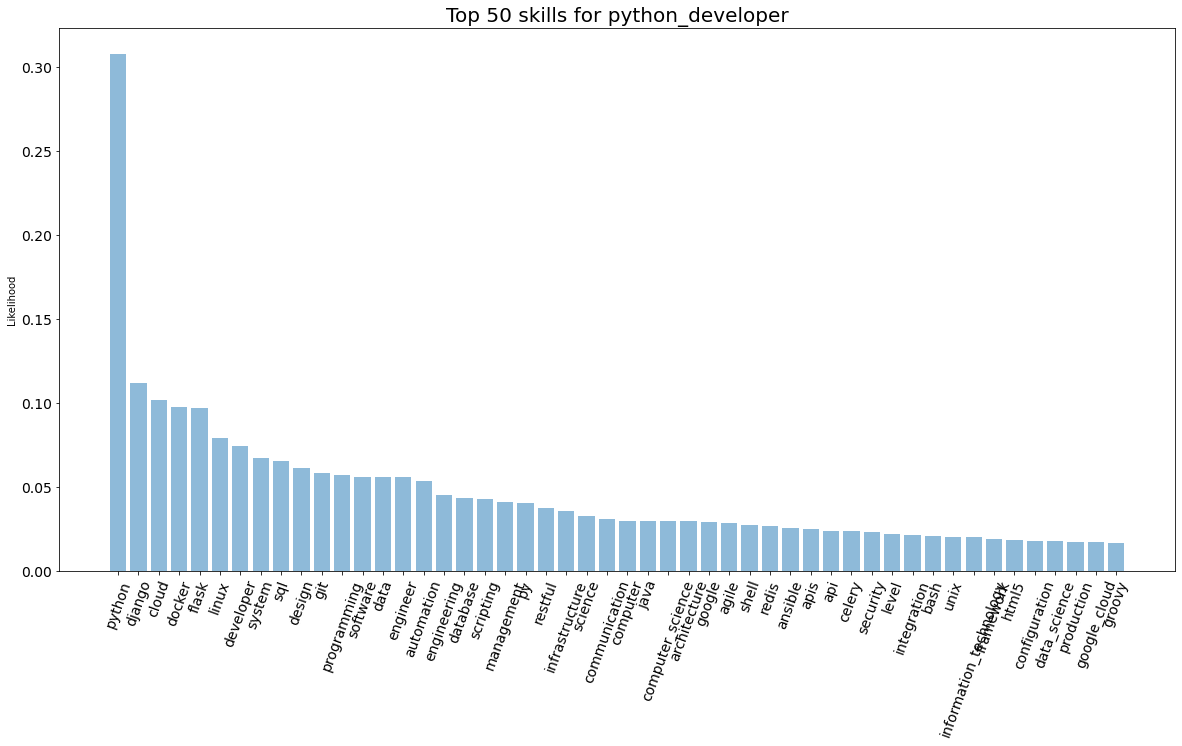

In [60]:
row = df_grouped[df_grouped['matching_column'] == 'python_developer']

sorted_python_skills = plot_skill_dist(row, top_n=50, show_plot=True)

### Persist results

In [61]:
def top_skills(d, percentile, perc=False):
    word_scores = d['word_scores']
    scores = {k: round(v['avg_likelihood'], 4) for k, v in word_scores.items()}
    skills = dict(sorted(scores.items(), key=itemgetter(1), reverse=True))
    limit = np.percentile(list(skills.values()), percentile)
    top_skills = dict(filter(lambda x: x[1]>limit, skills.items())) 
    if perc:
        skills = {k: round(v['percentile'], 2) for k, v in word_scores.items()}
        top_skills = dict(filter(lambda x: x[1] > percentile/100, skills.items()))
        top_skills = dict(sorted(top_skills.items(), key=itemgetter(1), reverse=True))
    return top_skills

In [62]:
df_grouped['top_skills'] = df_grouped.apply(lambda x: top_skills(x, 95), axis=1)

df_grouped['top_skills_percentile'] = df_grouped.apply(lambda x: top_skills(x, 95, perc=True), axis=1)

df_grouped['top_skills_count'] = df_grouped.apply(lambda x: len(x['top_skills']), axis=1)

df_grouped = df_grouped.rename(columns={'matching_column': 'job_title'})
df_grouped.head()

,job_title,word_scores,top_skills,top_skills_percentile,top_skills_count
0,.net_developer,{'salary': {'avg_likelihood': 0.01392943943531...,"{'.net': 0.2091, 'developer': 0.1958, 'sql': 0...","{'.net': 99.86, 'developer': 99.73, 'sql': 99....",37
1,account_manager,{'professional': {'avg_likelihood': 0.33752095...,"{'communication': 0.6002, 'representative': 0....","{'communication': 99.31, 'representative': 98....",8
2,agile_coach,{'leadership': {'avg_likelihood': 0.0509262359...,"{'scrum': 0.6012, 'scrum_master': 0.4846, 'saf...","{'scrum': 99.57, 'scrum_master': 99.14, 'safe'...",12
3,android_developer,{'data': {'avg_likelihood': 0.0823627634640180...,"{'android': 0.5312, 'kotlin': 0.4162, 'develop...","{'android': 99.78, 'kotlin': 99.56, 'developer...",23
4,application_developer,{'data': {'avg_likelihood': 0.0176977626174460...,"{'developer': 0.1864, 'java': 0.1474, 'sql': 0...","{'developer': 99.76, 'java': 99.53, 'sql': 99....",22


In [63]:
df_grouped['top_skills_percentile'] = df_grouped.apply(lambda x: top_skills(x, 95, perc=True), axis=1)
df_grouped['top_skills_count'] = df_grouped.apply(lambda x: len(x['top_skills']), axis=1)
df_grouped = df_grouped.rename(columns={'matching_column': 'job_title'})
df_grouped.head()

,job_title,word_scores,top_skills,top_skills_percentile,top_skills_count
0,.net_developer,{'salary': {'avg_likelihood': 0.01392943943531...,"{'.net': 0.2091, 'developer': 0.1958, 'sql': 0...","{'.net': 99.86, 'developer': 99.73, 'sql': 99....",37
1,account_manager,{'professional': {'avg_likelihood': 0.33752095...,"{'communication': 0.6002, 'representative': 0....","{'communication': 99.31, 'representative': 98....",8
2,agile_coach,{'leadership': {'avg_likelihood': 0.0509262359...,"{'scrum': 0.6012, 'scrum_master': 0.4846, 'saf...","{'scrum': 99.57, 'scrum_master': 99.14, 'safe'...",12
3,android_developer,{'data': {'avg_likelihood': 0.0823627634640180...,"{'android': 0.5312, 'kotlin': 0.4162, 'develop...","{'android': 99.78, 'kotlin': 99.56, 'developer...",23
4,application_developer,{'data': {'avg_likelihood': 0.0176977626174460...,"{'developer': 0.1864, 'java': 0.1474, 'sql': 0...","{'developer': 99.76, 'java': 99.53, 'sql': 99....",22


In [64]:
df_grouped['word_scores'] = df_grouped['word_scores'].astype('str')
df_grouped['word_scores'] = df_grouped['top_skills'].astype('str')
df_grouped['word_scores'] = df_grouped['top_skills_percentile'].astype('str')

In [65]:
df_grouped.to_csv('data/top_skills_by_job_title_percentiles.csv', index=False)

### Additional Model Evaluation & Visualization
As mentioned in the spike report, more work needs to be done to build a thorough strategy on model evaluation and performance. Given that this is a generative statistical model (unsupervised), there is no error to minimize, but only some metrics like __perplexity__ and __coherence__ that can give us some sense of comparison between models.

For perplexity, the lower the score, the better the model. The opposite is true for coherence.

In [66]:
def get_top_topic(row):
    return max(row['topics'], key=itemgetter(1))[0]

In [67]:
df_lda_training['top_topic'] =df_lda_training.apply(get_top_topic, axis=1)

In [68]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.352781662292625

Coherence Score:  0.5530641197342129


### Topic Visualization
with dimensionality reduction, we can see a simplified version of the topic space. It is an interactive tool, so feel free to play around with the UI

The Intertopic Distance Map shows the semantic relationships between topics. If you click on one of the blobs, you'll see the associated words for that topic number on the right. The relevance metric can be adjusted as well to see what word associations are brought up at different thresholds of relevance. More information on this lambda parameter can be found at the below resources (original white paper).

You can also click on the words on the right to see the topics in which they appear and with what degree of frequency.

It should be noted that these topics are not in perfect alignment with what a naive expectation might be for the original number of job titles, which was 67. At the time of this experiment, very little job title normalization (just some seniority fixing) was inorporated into the pre-processing, so there is a massive cardinality of job titles (apprx 40k). I only took the titles that had direct matches with what we have in our knowledge graph, which is also missing some key titles.

#### Resources:
- [general usage tips & link to white paper](https://github.com/bmabey/pyLDAvis#usage)
- [helpful video in describing use of the tool](https://www.youtube.com/watch?v=IksL96ls4o0&ab_channel=PyData)

In [69]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/tom.mctavish/Library/Caches/pypoetry/virtualenvs/match-2141-LieH_8B5-py3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tom.mctavish/Library/Caches/pypoetry/virtualenvs/match-2141-LieH_8B5-py3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tom.mctavish/Library/Caches/pypoetry/virtualenvs/match-2141-LieH_8B5-py3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tom.mctavish/Library/Caches/pypoetry/virtualenvs/match-2141-LieH_8B5-py3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: Deprec

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18    -0.064605 -0.099997       1        1  9.600465
10    -0.233516 -0.123145       2        1  9.519517
4     -0.190152  0.049862       3        1  7.885231
21     0.119567  0.173915       4        1  7.483295
8      0.042073 -0.040340       5        1  5.724062
14    -0.102145 -0.129875       6        1  5.635062
12     0.132836 -0.018846       7        1  5.404606
13    -0.172472  0.120653       8        1  5.170876
2     -0.061147  0.014387       9        1  4.665732
6      0.002871  0.121755      10        1  4.515203
20     0.130133 -0.088981      11        1  4.190289
0      0.045787 -0.187546      12        1  4.059533
17     0.216814 -0.166827      13        1  4.051697
19    -0.089313  0.038065      14        1  3.806006
5     -0.097937 -0.085371      15        1  3.007514
3      0.151238 -0.022052      16        1  2.911020
7     -0.011270 -0.061439      17        1  2.746873
1      0.021534  0.220415      18        1  2.615420
15    -0.169537 -0.009372      19        1  2.192345
9      0.216015  0.024786      20        1  2.080163
16     0.016967  0.225904      21        1  1.661669
11     0.096258  0.044050      22        1  1.073424, topic_info=         Term          Freq         Total Category  logprob  loglift
4        data  23055.000000  23055.000000  Default  30.0000  30.0000
19     system  17737.000000  17737.000000  Default  29.0000  29.0000
112   network   7382.000000   7382.000000  Default  28.0000  28.0000
69       java   7042.000000   7042.000000  Default  27.0000  27.0000
76   security   5434.000000   5434.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
179    expect     26.439398    747.593330  Topic22  -5.2209   1.1923
17    science     28.706827   4222.567256  Topic22  -5.1387  -0.4567
65   engineer     26.608004   7452.151804  Topic22  -5.2146  -1.1007
409         c     23.022206   1360.864628  Topic22  -5.3593   0.4549
19     system     23.272899  17737.847623  Topic22  -5.3485  -2.1018

[1368 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1342      2  0.343751    .net
1342      6  0.655203    .net
210      14  0.000777    401k
210      17  0.085476    401k
210      18  0.913041    401k
...     ...       ...     ...
1391      5  0.966291     xsd
1349      2  0.990149    xslt
1117      1  0.968133    yaml
1743     20  0.908743  zabbix
1372     19  0.904298  zephyr

[2985 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 11, 5, 22, 9, 15, 13, 14, 3, 7, 21, 1, 18, 20, 6, 4, 8, 2, 16, 10, 17, 12])

### Explore topic groupings
It can be obsserved that for a given topic number, there can be any collection of job titles. This is partly why it was necessary to collect averages by job title and not be overly committed to the exact topic number assignment that the model provides

In [71]:
df_lda_training[df_lda_training['top_topic'] == 1].iloc[:10][['matching_column', 'job_skills', 'skills_only',
                                                        'word_scores','topics', 'top_topic']]

,matching_column,job_skills,skills_only,word_scores,topics,top_topic
111,data_scientist,"[IT, SAS, Python, SQL, Management, Analysis]","[data, scientist, salary, fit, salary, governm...","{'data': 0.26117473032488825, 'professional': ...","[(1, 0.64517874), (13, 0.33461878)]",1
113,data_scientist,"[IT, SAS, Python, SQL, Management, Analysis]","[data, scientist, salary, fit, salary, governm...","{'data': 0.26122391380066873, 'professional': ...","[(1, 0.64513427), (13, 0.3346632)]",1
122,data_scientist,"[IT, SAS, Python, SQL, Management, Analysis]","[data, scientist, salary, fit, salary, governm...","{'data': 0.26118606538622974, 'professional': ...","[(1, 0.6451685), (13, 0.33462897)]",1
140,data_scientist,"[IT, SAS, Python, SQL, Management, Analysis]","[data, scientist, salary, fit, salary, governm...","{'data': 0.26118975617763396, 'professional': ...","[(1, 0.6451653), (13, 0.3346321)]",1
142,data_scientist,"[IT, SAS, Python, SQL, Management, Analysis]","[data, scientist, salary, fit, salary, governm...","{'data': 0.26116436832146644, 'professional': ...","[(1, 0.64518803), (13, 0.33460942)]",1
144,data_scientist,"[IT, SAS, Python, SQL, Management, Analysis]","[data, scientist, salary, fit, salary, governm...","{'data': 0.2612160755631924, 'professional': 0...","[(1, 0.64514154), (13, 0.33465594)]",1
146,data_scientist,"[IT, SAS, Python, SQL, Management, Analysis]","[data, scientist, salary, fit, salary, governm...","{'data': 0.2611636704954386, 'professional': 0...","[(1, 0.645189), (13, 0.33460853)]",1
148,data_scientist,"[IT, SAS, Python, SQL, Management, Analysis]","[data, scientist, salary, fit, salary, governm...","{'data': 0.26117629654831886, 'professional': ...","[(1, 0.6451774), (13, 0.33462)]",1
150,data_scientist,"[IT, SAS, Python, SQL, Management, Analysis]","[data, scientist, salary, fit, salary, governm...","{'data': 0.26122132390126585, 'professional': ...","[(1, 0.64513683), (13, 0.33466068)]",1
312,mechanical_engineer,"[Engineer, Management, Mechanical, Engineering...","[oil, automotive, focus, innovation, engineer,...","{'communication': 0.09822851, 'data': 0.002035...","[(1, 0.20140554), (11, 0.16593198), (4, 0.1608...",1


### Finding an optimal Coherence Value
Here we can begin tuning the model for coherence. As previously mentioned, this is still very much a work in progress, and should be used with scrutiny

In [72]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics, 
                         random_state=100,
                         chunksize=100,
                         passes=15,
                         alpha='symmetric',
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Note: running this may take some time as it has to retrain the model 12 times
It would make sense to see a more granular approach once a trend is established. We can use a smaller step size to see how coherence changes for additional values of _k_.

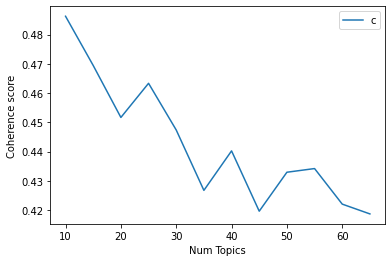

CPU times: user 2min 29s, sys: 29.2 s, total: 2min 58s
Wall time: 7min 28s


In [73]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=docs, start=10, limit=70, step=5)
limit=70; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [74]:
coherence_values.index(max(coherence_values))

0

In [75]:
# ideal number of topics and corresponding coherence score
print(model_list[1].num_topics)
print(coherence_values[1])

15
0.46942703697673294
